In [8]:
# load npz files
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

def load_npz_files(directory):
    npz_files = [f for f in os.listdir(directory) if f.endswith('.npz')]
    data = {}
    for npz_file in npz_files:
        file_path = os.path.join(directory, npz_file)
        with np.load(file_path) as npz_data:
            data[npz_file] = {key: value for key, value in npz_data.items()}
    return data

def visualize_data(data):
    for npz_file, contents in data.items():
        print(f"Contents of {npz_file}:")
        if len(contents) > 1:
            value = contents.get('img')
            value = value.squeeze()
            print(f"  img: shape {value.shape}, dtype {value.dtype}")
            if value.shape[-1] != 3:
                # repeat the last channel if not 3 channels
                value = np.repeat(value[..., np.newaxis], 3, axis=-1)
            # value = np.transpose(value, (1, 2, 0))
            print(np.mean(value), np.std(value))
            if value.ndim == 3:  # Assuming image data is 3D (H, W, C)
                plt.imshow(value)
                plt.title(f"{npz_file} - {key}")
                plt.axis('off')
                plt.show()
        else:
            for key, value in contents.items():
                value = value.squeeze()
                if value.shape[-1] != 3:
                    value = np.transpose(value, (1, 2, 0))
                print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
                print(np.mean(value), np.std(value))
                if value.ndim == 3:  # Assuming image data is 3D (H, W, C)
                    plt.imshow(value)
                    plt.title(f"{npz_file} - {key}")
                    plt.axis('off')
                    plt.show()

Loaded 4 npz files.
Contents of test_img.npz:
  img: shape (256, 216, 3), dtype float64
0.1505024651643065 0.13477584450947766


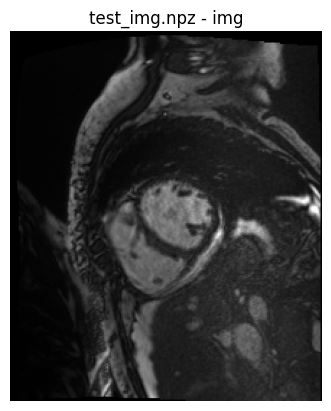

Contents of test_img_256.npz:
  img_256: shape (256, 256, 3), dtype float32
0.20143306 0.21317317


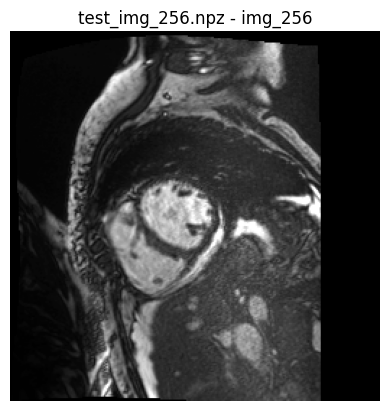

Contents of patient018_frame01_2.npz:
  img: shape (256, 216), dtype float32
0.26547894 0.22426225


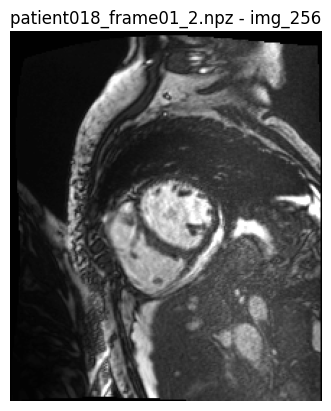

Contents of test_img_256_tensor.npz:
  img_256_tensor: shape (256, 256, 3), dtype float32
0.21785837 0.22765693


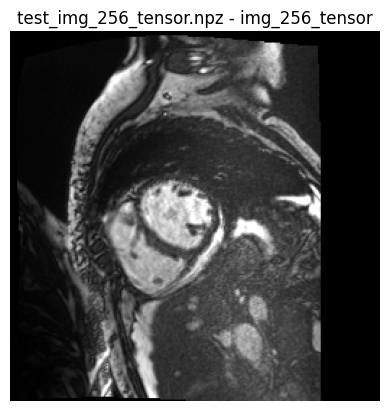

In [15]:
data = load_npz_files('/Users/i/ICL/fusion/code')
print(f"Loaded {len(data)} npz files.")
visualize_data(data)

In [10]:
# LiteMedSAM
x = np.transpose(data["test_img_256.npz"]["img_256"].squeeze(0), (1, 2, 0))
# ensemble proprocess
y = data["patient018_frame01_2.npz"]["img"]
if y.shape[-1] != 3:
    # repeat the last channel if not 3 channels
    y = np.repeat(y[..., np.newaxis], 3, axis=-1)

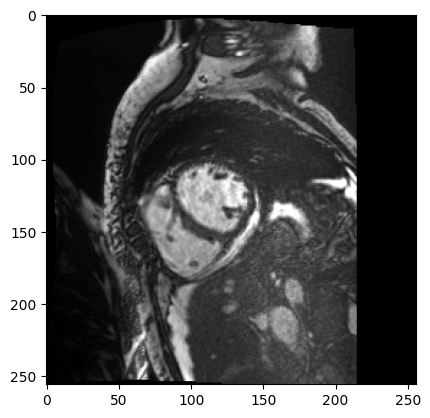

In [4]:
plt.imshow(x)

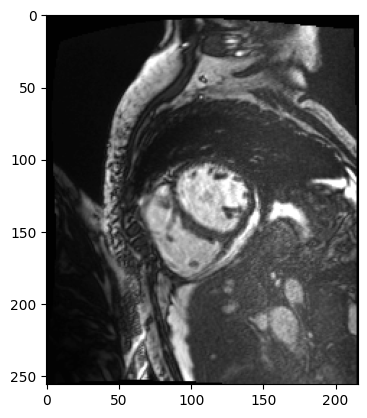

In [11]:
plt.imshow(y)

In [6]:
import h5py
import os
import re
from torch.utils.data import Dataset

class ACDCDataset(Dataset):
    def __init__(self, base_dir=None, split='train', transform=None, fold="fold1", sup_type="label"):
        self._base_dir = base_dir
        self.sample_list = []
        self.split = split
        self.sup_type = sup_type
        self.transform = transform
        # if self.split == "train" or self.split == "val":
        #     train_ids, test_ids = self._get_fold_ids(fold)
        if self.split == 'train':
            self.all_volumes = os.listdir(
                self._base_dir + "/ACDC_training_volumes")
            self.sample_list = []
            self.sample_list.extend(self.all_volumes)
            # self.all_slices = os.listdir(
            #     self._base_dir + "/ACDC_training_slices")
            # self.sample_list = []
            # for ids in train_ids:
            #     new_data_list = list(filter(lambda x: re.match(
            #         '{}.*'.format(ids), x) != None, self.all_slices))
            #     self.sample_list.extend(new_data_list)
        # elif self.split == 'val':
        #     self.all_volumes = os.listdir(
        #         self._base_dir + "/ACDC_training_volumes")
        #     self.sample_list = []
        #     for ids in test_ids:
        #         new_data_list = list(filter(lambda x: re.match(
        #             '{}.*'.format(ids), x) != None, self.all_volumes))
        #         self.sample_list.extend(new_data_list)
        else:
            self.all_volumes = os.listdir(
                self._base_dir + "/ACDC_testing_volumes")
            self.sample_list = []
            self.sample_list.extend(self.all_volumes)

        # if num is not None and self.split == "train":
        #     self.sample_list = self.sample_list[:num]
        print("total {} samples".format(len(self.sample_list)))

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx]
        if self.split == "train":
            h5f = h5py.File(self._base_dir +
                            "/ACDC_training_volumes/{}".format(case), 'r')
        elif self.split == "val":
            h5f = h5py.File(self._base_dir +
                            "/ACDC_training_volumes/{}".format(case), 'r')
        else:
            h5f = h5py.File(self._base_dir +
                            "/ACDC_testing_volumes/{}".format(case), 'r')
        image = h5f['image'][:]
        label = h5f['label'][:]
        gt = h5f['label'][:]
        sample = {'image': image, 'label': label, 'gt': gt}
        # if self.split == "train":
        #     image = h5f['image'][:]
        #     label = h5f[self.sup_type][:]
        #     sample = {'image': image, 'label': label, 'gt': gt}
        #     if self.transform is not None:
        #         sample = self.transform(sample)
        # else:
        #     image = h5f['image'][:]
        #     label = h5f['label'][:]
        #     sample = {'image': image, 'label': label, 'gt': gt}
        sample["idx"] = idx
        return sample

In [7]:
from tqdm import tqdm

acdc_dataset = ACDCDataset(
        base_dir="/Users/i/ICL/fusion/code/data/ACDC/ACDC_preprocessed",
        split="train",
        transform=None,
    )

for sample in tqdm(acdc_dataset):
    # sample = {'image': image, 'label': label, 'gt': gt, 'idx': idx}
    image = sample['image']
    gt = sample['gt']
    idx = sample['idx']
    for slice_idx in range(gt.shape[0]):
        gt_slice = gt[slice_idx, :, :]
        image_slice = image[slice_idx, :, :]
        gt_name = acdc_dataset.sample_list[idx].split('.')[0] + "_" + str(slice_idx)
        # print(f"Processing {gt_name}")
        if gt_name == "patient018_frame01_2":
            print(f"Saving {gt_name} slice {slice_idx}")
            np.savez_compressed(f"patient018_frame01_2.npz", img=image_slice, gt=gt_slice)

total 200 samples


  6%|▋         | 13/200 [00:00<00:01, 116.88it/s]

Saving patient018_frame01_2 slice 2


100%|██████████| 200/200 [00:01<00:00, 106.06it/s]


(1024, 1024) (1024, 1024)
False

Number of differing pixels: 993058/1048576


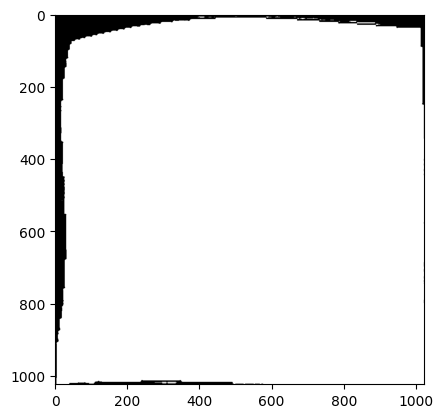

In [2]:
import cv2
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

img1 = io.imread("/Users/i/ICL/fusion/code/img.tif")
img2 = io.imread("/Users/i/ICL/fusion/code/MedSAM/img_medsam.tif")

print(img1.shape, img2.shape)
print(np.array_equal(img1, img2))
differences = (img1 != img2)
num_differing_pixels = np.sum(differences)
print(f"\nNumber of differing pixels: {num_differing_pixels}/{np.multiply(*img1.shape)}")
binary_map_np = (differences * 255).astype(np.uint8)
plt.imshow(binary_map_np, cmap="gray")

(256, 216) (256, 216)
False

Number of differing pixels: 52420/55296


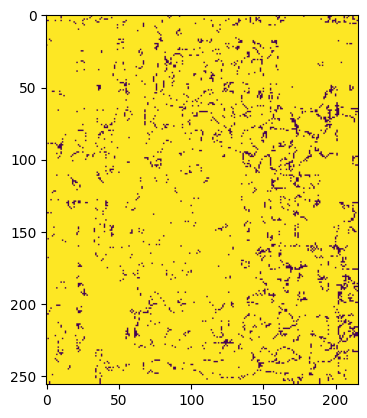

: 

In [ ]:
import cv2
from skimage import io
import numpy as np

img1 = io.imread("/Users/i/ICL/fusion/code/data/100K/SAMed2Dv1/mask_logits/SAM-Med2D/mr_00--ACDC--patient018_frame01--x_0002--0001_000_mask_logits.tif")
img2 = io.imread("/Users/i/ICL/fusion/code/SAM_Med2D/2_1.png_mask_logits.tif")

print(img1.shape, img2.shape)
print(np.array_equal(img1, img2))
differences = (img1 != img2)
num_differing_pixels = np.sum(differences)
print(f"\nNumber of differing pixels: {num_differing_pixels}/{np.multiply(*img1.shape)}")
binary_map_np = (differences * 255).astype(np.uint8)
plt.imshow(binary_map_np)

In [2]:
import numpy as np

loaded_data = np.load("/Users/i/Downloads/mr_00--AMOS2022--amos_0596--y_0081--0002_000_mask_logits.npz")
print(loaded_data["dice_loss"], loaded_data["bce_loss"], loaded_data["iou_loss"])

0.25852942 0.026193898 0.41084367
